# Calibration of a very large Pilatus detector with overlapping grid position

This tutorial presents the calibration of the Pilatus 900kw CdTe which is a very large 2D detector (4500x200) running at ESRF ID06-LVP .
The detector is so large that the grid needs to be displaced in front of the detector and the operation needs to be performed several times.

The overall strategy is very similar to the ID15 detector calibration, excepts that all needs to be done 3 times, one for each of the grid position: *left*, *center* and *right*:

1.  Image preprocessing
2.  Peak picking
3.  Grid assignment
4.  Displacement fitting
5.  Reconstruction of the pixel position
6.  Saving into a detector definition file
7.  Validation of the geometry with a 2D integration

Each module being made by lithographic processes, the error within a module will be assumeed to be constant. We will use the name "displacement of the module" to describe the rigide movement of the module.

This tutorial uses data acquired by Marie Ruat from the ESRF detector group during the commissionning of the detector. The ID06-LVP is acknowledged for commissionning beam-time and fruitful discussion.

This detector contains 18 half-modules, each bound to a single CdTe monocrystal sensor and is designed for high energy X-ray radiation detection. Due to the construction procedure, these half-modules could show a misalignment within the detector plane. While the manufacturer (Dectris) garanties a precision within a pixel (172µm), the miss-alignment of certain modules can be seen while calibrating Debye-Scherrer ring using refereance sample. So the aim of this work is to provide a detector description with a better precision better than the original detector.

This work will be performed on the image of a grid available: http://www.silx.org/pub/pyFAI/detector_calibration

It is a good exercise to calibrate all rings of the later image using the pyFAI-calib2 tool. A calibration close to perfection is needed to visualize the module miss-alignement we aim at correcting.


In [1]:
%matplotlib nbagg

In [2]:
#many imports which will be used all along the notebook
import time
start_time = time.time()
import os
import pyFAI
import fabio
import glob
import numpy
from numpy.lib.stride_tricks import as_strided
from collections import namedtuple
from math import sin, cos, sqrt
from scipy.ndimage import convolve, binary_dilation
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from matplotlib.pyplot import subplots
from pyFAI.ext.bilinear import Bilinear
from pyFAI.ext.watershed import InverseWatershed
from silx.resources import ExternalResources

print("Using pyFAI verison: ", pyFAI.version)

Triplet = namedtuple("Triplet", "left center right")

from matplotlib import colors
logcolor = colors.LogNorm(1e5, 3e5)
normcolor = colors.LogNorm(1, 2)

# Some compound types ...
dt = numpy.dtype([('y', numpy.float64),
                  ('x', numpy.float64),
                  ('i', numpy.int64)])

dl = numpy.dtype([('y', numpy.float64),
                  ('x', numpy.float64),
                  ('i', numpy.int64),
                  ('Y', numpy.int64),
                  ('X', numpy.int64)])

Using pyFAI verison:  0.20.0-dev0


In [3]:
#Download all data:
#Nota: Configure here your proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.comany.com:3128"
downloader = ExternalResources("detector_calibration", "http://www.silx.org/pub/pyFAI/detector_calibration/")
median21_left = downloader.getfile("Pilatus900kwID06_median21_left.npy")
median21_center = downloader.getfile("Pilatus900kwID06_median21_center.npy")
median21_right = downloader.getfile("Pilatus900kwID06_median21_right.npy")
mask_left = downloader.getfile("Pilatus900kwID06_mask_left.npy")
mask_center = downloader.getfile("Pilatus900kwID06_mask_center.npy")
mask_right = downloader.getfile("Pilatus900kwID06_mask_right.npy")
minimum = downloader.getfile("Pilatus900kwID06_minimum.npy")

<IPython.core.display.Javascript object>


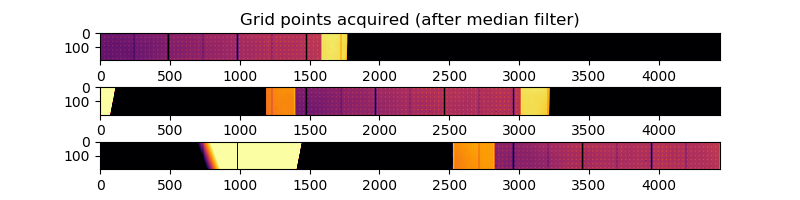

In [4]:
img_left = fabio.open(median21_left).data
img_center = fabio.open(median21_center).data
img_right = fabio.open(median21_right).data
fig,ax = subplots(3, figsize=(8,2))
ax[0].set_title("Grid points acquired (after median filter)")
ax[0].imshow(img_left, interpolation="bilinear", norm=logcolor, cmap="inferno")
ax[1].imshow(img_center, interpolation="bilinear", norm=logcolor, cmap="inferno")
ax[2].imshow(img_right, interpolation="bilinear", norm=logcolor, cmap="inferno")

<IPython.core.display.Javascript object>


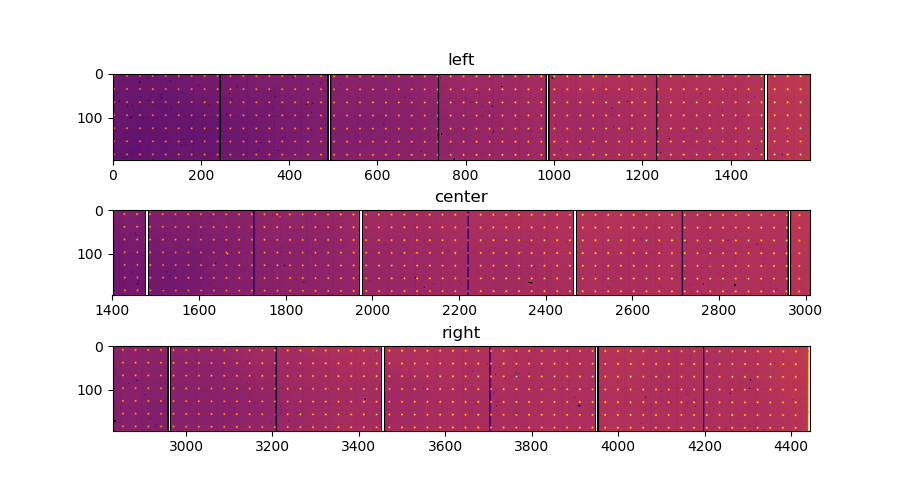

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b6e05c70>,
      dtype=object)

In [5]:
def display(triplet, **kwargs):
    fig,ax = subplots(3, figsize=(9,5))
    ax[0].set_title("left")
    ax[0].imshow(triplet.left, **kwargs)
    ax[0].set_xlim(0, 1580)
    ax[1].set_title("center")
    ax[1].imshow(triplet.center, **kwargs)
    ax[1].set_xlim(1400, 3010)
    ax[2].set_title("right")
    ax[2].imshow(triplet.right, **kwargs)
    ax[2].set_xlim(2830, triplet.right.shape[-1]+5)
    return ax
data = Triplet(img_left, img_center, img_right)
display(data, interpolation="bilinear", norm=logcolor, cmap="inferno")


## Image processing

There are 4 pre-processing steps which are needed.

* Define for each module a unique identifier which will be used later on during the fitting procedure
* Define the proper mask: each module is the assembly of 4x2 sub-modules and there are (3) interpolated pixels between each sub-module, such “unreliable pixels should be masked out as well
* Correct the grid image by the smoothed image to have a constant background.
* Convolve the raw image with a typical hole shape to allow a precise spotting of the hole center.


In [6]:
pilatus = pyFAI.detector_factory("Pilatus_900kw_CdTe")
print(pilatus)
print(pilatus.shape)
mask1 = pilatus.mask
module_size = pilatus.MODULE_SIZE
module_gap = pilatus.MODULE_GAP
submodule_size = (96,60)

Detector Pilatus CdTe 900kw	 PixelSize= 1.720e-04, 1.720e-04 m
(195, 4439)


In [7]:
#1 + 2 Calculation of the module_id and the interpolated-mask:
mid = numpy.zeros(pilatus.shape, dtype=int)
mask2 = numpy.zeros(pilatus.shape, dtype=int)
idx = 1
for i in range(1):
    y_start = i*(module_gap[0] + module_size[0])
    y_stop = y_start + module_size[0]
    for j in range(9):
        x_start = j*(module_gap[1] + module_size[1])
        x_stop = x_start + module_size[1]
        mid[y_start:y_stop,x_start: x_start+module_size[1]//2] = idx
        idx+=1
        mid[y_start:y_stop,x_start+module_size[1]//2: x_stop] = idx
        idx+=1
        mask2[y_start+submodule_size[0]-1:y_start+submodule_size[0]+2,
              x_start:x_stop] = 1
        for k in range(1,8):
            mask2[y_start:y_stop,
              x_start+k*(submodule_size[1]+1)-1:x_start+k*(submodule_size[1]+1)+2] = 1



<IPython.core.display.Javascript object>


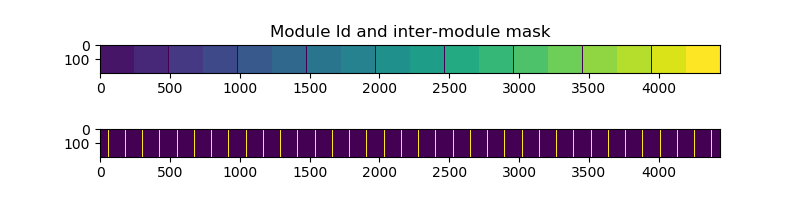

In [8]:
fix, ax = subplots(2, figsize=(8,2))
ax[0].set_title("Module Id and inter-module mask")
ax[0].imshow(mid)
ax[1].imshow(mask2)

In [9]:
#Extra masking: bad pixels marked by the detector
mask0 = fabio.open(minimum).data<0

<IPython.core.display.Javascript object>


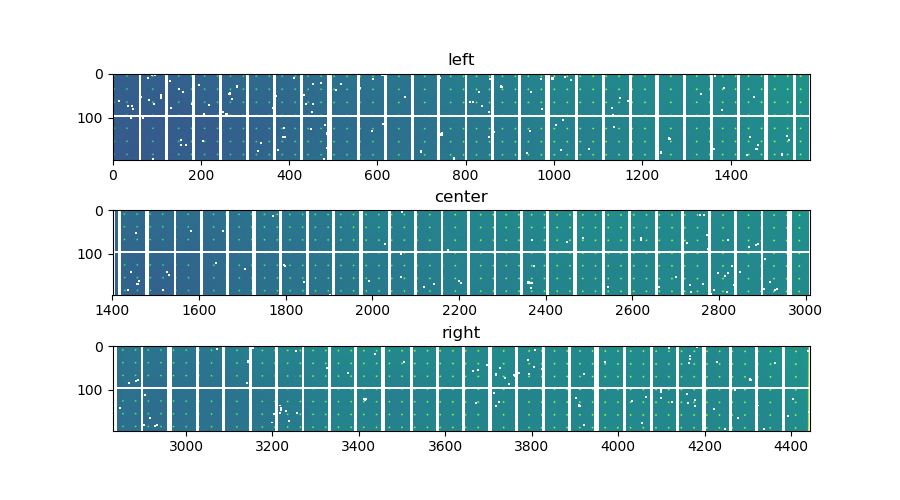

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b3ee66a0>,
      dtype=object)

In [10]:
bad = numpy.where(mask0 | mask1 | mask2 | fabio.open(mask_left).data)
data.left[bad] = numpy.nan
bad = numpy.where(mask0 | mask1 | mask2 | fabio.open(mask_center).data)
data.center[bad] = numpy.nan
bad = numpy.where(mask0 | mask1 | mask2 | fabio.open(mask_right).data)
data.right[bad] = numpy.nan

display(data, interpolation="bilinear", norm=logcolor)


In [11]:
# The Nan-masked image contains now only valid values (and Nan elsewhere). We will make a large median filter to
# build up a smooth image without gaps.
#
# This function is backported from future version of numpy ... it allows to expose a winbowed view
# to perform the nanmedian-filter

def sliding_window_view(x, shape, subok=False, readonly=True):
    """
    Creates sliding window views of the N dimensional array with the given window
    shape. Window slides across each dimension of `x` and extract subsets of `x`
    at any window position.
    Parameters
    ----------
    x : array_like
        Array to create sliding window views of.
    shape : sequence of int
        The shape of the window. Must have same length as the number of input array dimensions.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise the returned
        array will be forced to be a base-class array (default).
    readonly : bool, optional
        If set to True, the returned array will always be readonly view.
        Otherwise it will return writable copies(see Notes).
    Returns
    -------
    view : ndarray
        Sliding window views (or copies) of `x`. view.shape = x.shape - shape + 1
    See also
    --------
    as_strided: Create a view into the array with the given shape and strides.
    broadcast_to: broadcast an array to a given shape.
    Notes
    -----
    ``sliding_window_view`` create sliding window views of the N dimensions array
    with the given window shape and its implementation based on ``as_strided``.
    Please note that if readonly set to True, views are returned, not copies
    of array. In this case, write operations could be unpredictable, so the returned
    views are readonly. Bear in mind that returned copies (readonly=False) will
    take more memory than the original array, due to overlapping windows.
    For some cases there may be more efficient approaches to calculate transformations
    across multi-dimensional arrays, for instance `scipy.signal.fftconvolve`, where combining
    the iterating step with the calculation itself while storing partial results can result
    in significant speedups.
    Examples
    --------
    >>> i, j = np.ogrid[:3,:4]
    >>> x = 10*i + j
    >>> shape = (2,2)
    >>> np.lib.stride_tricks.sliding_window_view(x, shape)
    array([[[[ 0,  1],
             [10, 11]],
            [[ 1,  2],
             [11, 12]],
            [[ 2,  3],
             [12, 13]]],
           [[[10, 11],
             [20, 21]],
            [[11, 12],
             [21, 22]],
            [[12, 13],
             [22, 23]]]])
    """
    np = numpy
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    try:
        shape = np.array(shape, np.int)
    except:
        raise TypeError('`shape` must be a sequence of integer')
    else:
        if shape.ndim > 1:
            raise ValueError('`shape` must be one-dimensional sequence of integer')
        if len(x.shape) != len(shape):
            raise ValueError("`shape` length doesn't match with input array dimensions")
        if np.any(shape <= 0):
            raise ValueError('`shape` cannot contain non-positive value')

    o = np.array(x.shape) - shape  + 1 # output shape
    if np.any(o <= 0):
        raise ValueError('window shape cannot larger than input array shape')

    if type(readonly) != bool:
        raise TypeError('readonly must be a boolean')

    strides = x.strides
    view_strides = strides

    view_shape = np.concatenate((o, shape), axis=0)
    view_strides = np.concatenate((view_strides, strides), axis=0)
    view = as_strided(x, view_shape, view_strides, subok=subok, writeable=not readonly)

    if not readonly:
        return view.copy()
    else:
        return view

In [12]:
%%time
#Calculate a background image using a large median filter ... takes a while
shape = (13,13)
padded = Triplet(*(numpy.pad(i, tuple((i//2,) for i in shape), mode="edge") for i in data))
print(padded.left.shape)

(207, 4451)
CPU times: user 3.83 ms, sys: 3.89 ms, total: 7.72 ms
Wall time: 7.37 ms


In [13]:
%%time 
background = Triplet(*[numpy.nanmedian(sliding_window_view(i, shape), axis = (-2,-1)) for i in padded])
print(background.left.shape)

/users/kieffer/.venv/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(195, 4439)
CPU times: user 13.7 s, sys: 965 ms, total: 14.7 s
Wall time: 14.7 s


<IPython.core.display.Javascript object>


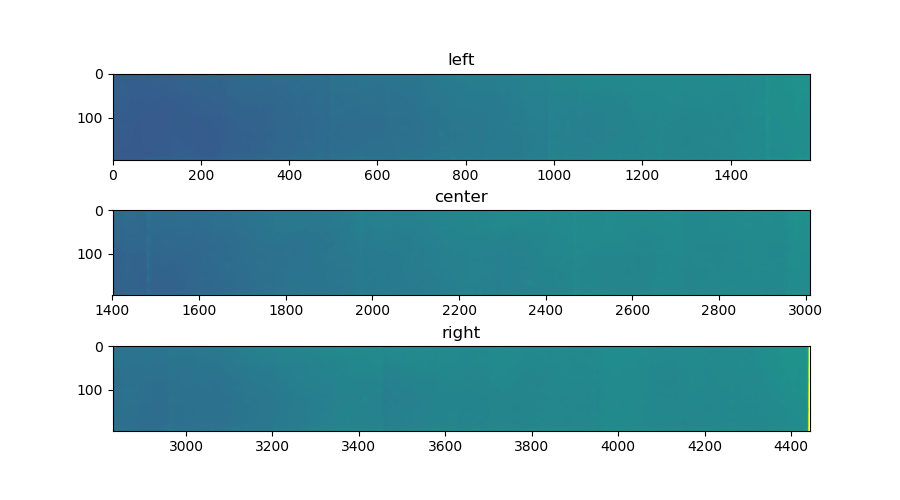

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb887777040>,
      dtype=object)

In [14]:
display(background, norm=logcolor, interpolation="bilinear")

<IPython.core.display.Javascript object>


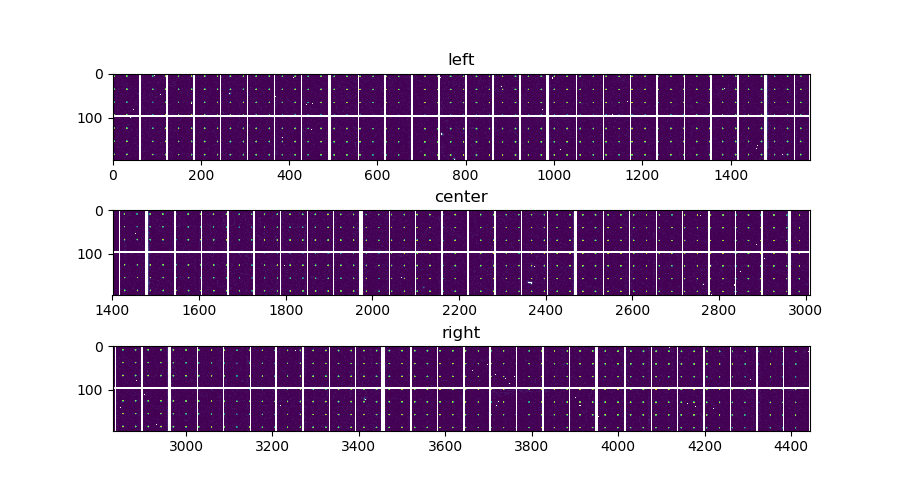

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b30d5160>,
      dtype=object)

In [15]:
normalized = Triplet(*(i/j for i,j in zip(data, background)))
display(normalized, interpolation="nearest", norm=normcolor)

<IPython.core.display.Javascript object>


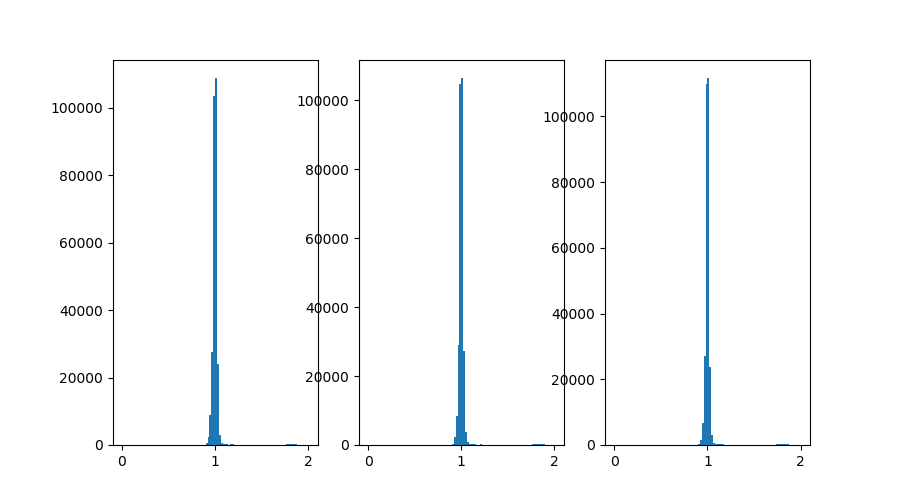

/users/kieffer/.venv/py38/lib/python3.8/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/kieffer/.venv/py38/lib/python3.8/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.10000e+01, 8.20000e+01,
        7.80000e+01, 1.80000e+01, 1.00000e+00, 1.00000e+00, 1.30000e+01,
        6.10000e+01, 1.11000e+02, 8.00000e+00, 0.00000e+00, 4.00000e+00,
        0.00000e+00, 1.00000e+00, 3.00000e+00, 1.20000e+01, 4.80000e+01,
        3.23000e+02, 1.61800e+03, 6.84500e+03, 2.71710e+04, 1.09911e+05,
        1.11592e+05, 2.38050e+04, 2.90600e+03, 6.07000e+02, 2.84000e+02,
        2.03000e+02, 1.99000e+02, 1.82000e+02, 1.60000e+02, 1.44000e+02,
        1.19000e+02, 1.21000e+02, 1.16000e+02, 1.26000e+02, 9.80000e+01,
        1.03000e+02, 1.02000e+02, 1.05000e+02, 1.16

In [16]:
fig,ax = subplots(1,3, figsize=(9,5))

ax[0].hist(normalized.left.ravel(), 100, range=(0,2))
ax[1].hist(normalized.center.ravel(), 100, range=(0,2))
ax[2].hist(normalized.right.ravel(), 100, range=(0,2))

For a precise measurement of the peak position, one trick is to convolve the image with a pattern which looks like a hole of the grid.

15.439885086158014


<IPython.core.display.Javascript object>


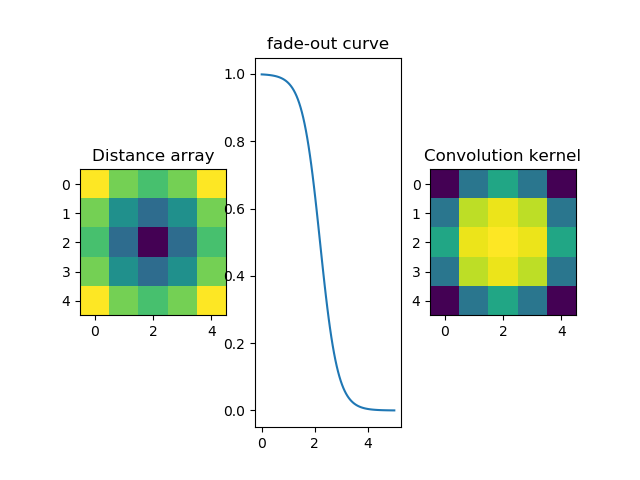

Text(0.5, 1.0, 'Convolution kernel')

In [17]:
#Definition of the convolution kernel
ksize = 5
y,x = numpy.ogrid[-(ksize-1)//2:ksize//2+1,-(ksize-1)//2:ksize//2+1]
d = numpy.sqrt(y*y+x*x)

#Fade out curve definition
fadeout = lambda x: 1/(1+numpy.exp(3*(x-2.2)))

kernel = fadeout(d)
mini=kernel.sum()
print(mini)

fig,ax = subplots(1,3)
ax[0].imshow(d)
ax[0].set_title("Distance array")

ax[1].plot(numpy.linspace(0,5,100),fadeout(numpy.linspace(0,5,100)))
ax[1].set_title("fade-out curve")

ax[2].imshow(kernel)
ax[2].set_title("Convolution kernel")

(195, 4439)


<IPython.core.display.Javascript object>


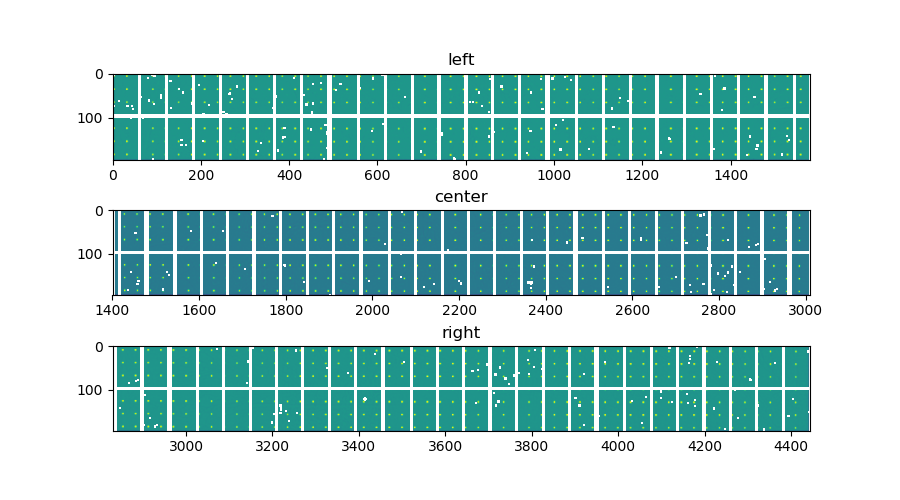

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b2fec1c0>,
      dtype=object)

In [18]:
my_smooth = Triplet(*(convolve(i, kernel, mode="constant", cval=0)/mini for i in normalized))
print(my_smooth.center.shape)
display(my_smooth)

In [19]:
all_masks = mask0 | mask1 | mask2
big_mask = binary_dilation(all_masks, iterations=ksize//2+1+1)
print(all_masks.sum(), big_mask.sum())

62453 208997


## Peak picking

We use the watershed module from pyFAI to retrieve all peak positions. Those regions are sieved out respectively for:

*    their size, it should be larger than the kernel itself
*    the peaks too close to masked regions are removed
*    the intensity of the peak


In [20]:
%%time
tmp = []
for i in my_smooth:
    iw = InverseWatershed(i)
    iw.init()
    iw.merge_singleton()
    all_regions = set(iw.regions.values())
    regions = [i for i in all_regions if i.size>mini]
    tmp.append(regions)
regions = Triplet(*tmp)    

CPU times: user 5.15 s, sys: 183 ms, total: 5.33 s
Wall time: 5.31 s


In [21]:
#Remove peaks on masked region
sieved_region = Triplet(*([i for i in j if not big_mask[(i.index//pilatus.shape[-1], i.index%pilatus.shape[-1])]] 
                          for j in regions))
print("Number of peaks not on masked areea : %s %s %s"%
      (len(sieved_region[0]),len(sieved_region[1]),len(sieved_region[2])))


Number of peaks not on masked areea : 4773 4772 4885


<IPython.core.display.Javascript object>


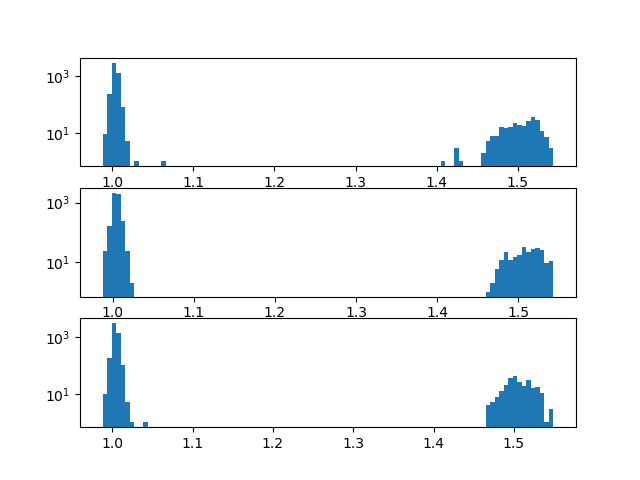

[None, None, None]

In [22]:
# Histogram of peak height:
s = Triplet(*(numpy.array([i.maxi for i in j]) for j in sieved_region))

fig, ax = subplots(3)
[ax[i].hist(s[i], 100) for i in range(3)]
[ax[i].set_yscale("log") for i in range(3)]

In [23]:
#sieve-out for peak intensity
int_mini = 1.2
peaks = Triplet(*([(i.index//pilatus.shape[-1], i.index%pilatus.shape[-1]) for i in j if (i.maxi)>int_mini]
                  for j in sieved_region))
print("Number of remaining peaks with I>%s: %s"%(int_mini, [len(i) for i in peaks]))

peaks_raw = Triplet(*(numpy.array(i) for i in peaks))

Number of remaining peaks with I>1.2: [248, 242, 252]


<IPython.core.display.Javascript object>


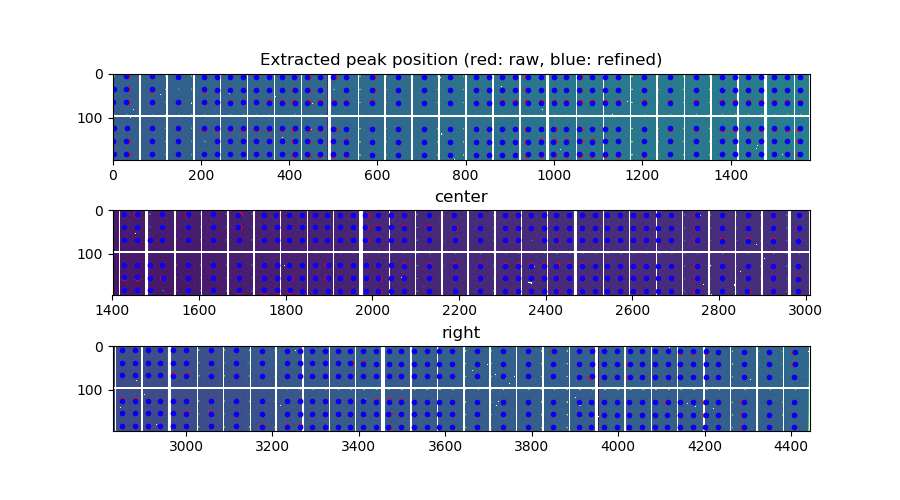

Text(0.5, 1.0, 'Extracted peak position (red: raw, blue: refined)')

In [24]:
# Finally the peak positions are interpolated using a second order taylor expansion
# in thevinicy of the maximum value of the signal:

#Create bilinear interpolator
bl = [Bilinear(i) for i in my_smooth]

#Overlay raw peak coordinate and refined peak positions

ref_peaks = [[b.local_maxi(p) for p in peaki] for b, peaki in zip(bl, peaks)]
ax = display(data)
peaks_ref = [numpy.array(i) for i in ref_peaks]
for i in range(3):
    ax[i].plot(peaks_raw[i][:,1], peaks_raw[i][:, 0], ".r")
    ax[i].plot(peaks_ref[i][:,1],peaks_ref[i][:, 0], ".b")
ax[0].set_title("Extracted peak position (red: raw, blue: refined)")


<IPython.core.display.Javascript object>


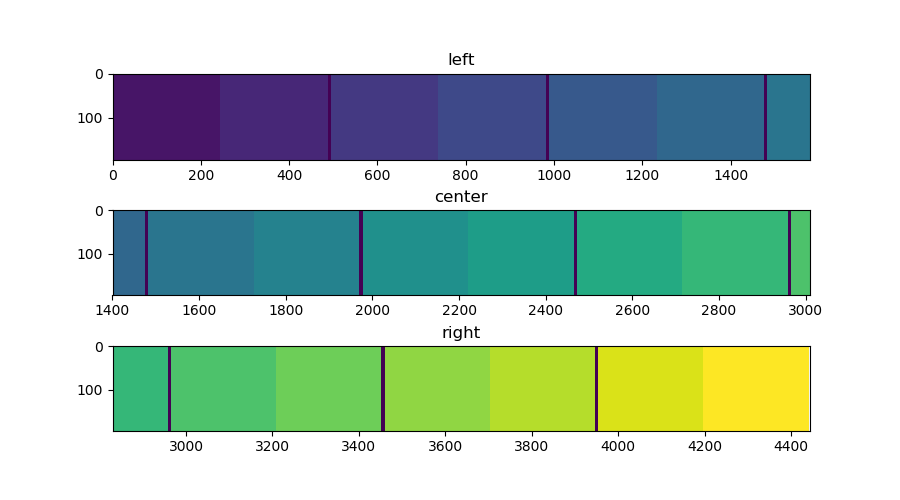

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b2b40d00>,
      dtype=object)

In [25]:
display(Triplet(mid, mid, mid))

At this stage we have about 3x250 peaks (with sub-pixel precision) which are visually distributed on all modules. Some modules have their peaks located along sub-module boundaries which are masked out, hence they have fewer ontrol point for the calculation. Let’s assign each peak to a module identifier. This allows to print out the number of peaks per module:

Number of keypoint per module:
Module id: 1 left cp: 33 center cp: 0 right cp: 0
Module id: 2 left cp: 48 center cp: 0 right cp: 0
Module id: 3 left cp: 29 center cp: 0 right cp: 0
Module id: 4 left cp: 42 center cp: 0 right cp: 0
Module id: 5 left cp: 42 center cp: 0 right cp: 0
Module id: 6 left cp: 36 center cp: 12 right cp: 0
Module id: 7 left cp: 18 center cp: 27 right cp: 0
Module id: 8 left cp: 0 center cp: 48 right cp: 0
Module id: 9 left cp: 0 center cp: 36 right cp: 0
Module id: 10 left cp: 0 center cp: 41 right cp: 0
Module id: 11 left cp: 0 center cp: 48 right cp: 0
Module id: 12 left cp: 0 center cp: 24 right cp: 24
Module id: 13 left cp: 0 center cp: 6 right cp: 30
Module id: 14 left cp: 0 center cp: 0 right cp: 48
Module id: 15 left cp: 0 center cp: 0 right cp: 42
Module id: 16 left cp: 0 center cp: 0 right cp: 30
Module id: 17 left cp: 0 center cp: 0 right cp: 48
Module id: 18 left cp: 0 center cp: 0 right cp: 30


<IPython.core.display.Javascript object>


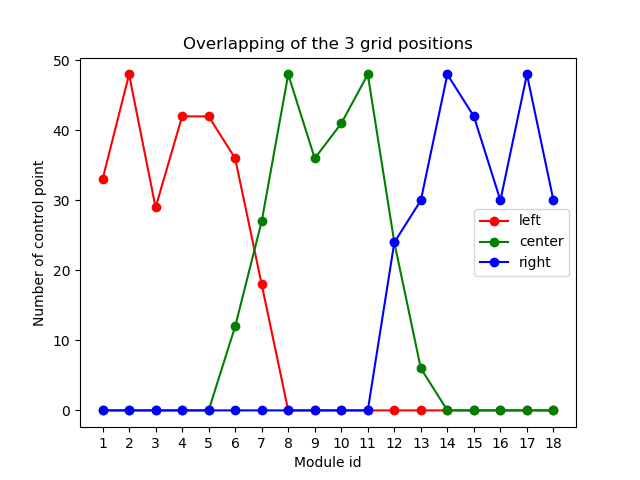

Text(0.5, 1.0, 'Overlapping of the 3 grid positions')

In [26]:
yxi = Triplet(*[numpy.array([i+(mid[round(i[0]),round(i[1])],)
                   for i in j], dtype=dt) 
                for j in ref_peaks])
print("Number of keypoint per module:")
cp = Triplet([numpy.NaN], [numpy.NaN], [numpy.NaN])
for i in range(1,mid.max()+1):
    cp.left.append((yxi.left[:]["i"] == i).sum())
    cp.center.append((yxi.center[:]["i"] == i).sum())
    cp.right.append((yxi.right[:]["i"] == i).sum())
    print("Module id:",i, 
          "left cp:", (yxi.left[:]["i"] == i).sum(), 
          "center cp:", (yxi.center[:]["i"] == i).sum(),
          "right cp:", (yxi.right[:]["i"] == i).sum())

fig, ax = subplots()
ax.plot(cp.left, "-or", label="left")
ax.plot(cp.center,"-og",  label="center")
ax.plot(cp.right,"-ob",  label="right")
ax.set_ylabel("Number of control point")
ax.set_xlabel("Module id")
ax.set_xticks(numpy.arange(1, 19))
ax.legend()
ax.set_title("Overlapping of the 3 grid positions")

## Grid assignment

The calibration is performed using a regular grid, the idea is to assign to each peak of coordinates (x,y) the integer value (X, Y) which correspond to the grid corrdinate system.

The first step is to measure the grid pitch which correspond to the distance (in pixels) from one peak to the next. This is easily obtained from a pair-wise distribution function.



<IPython.core.display.Javascript object>


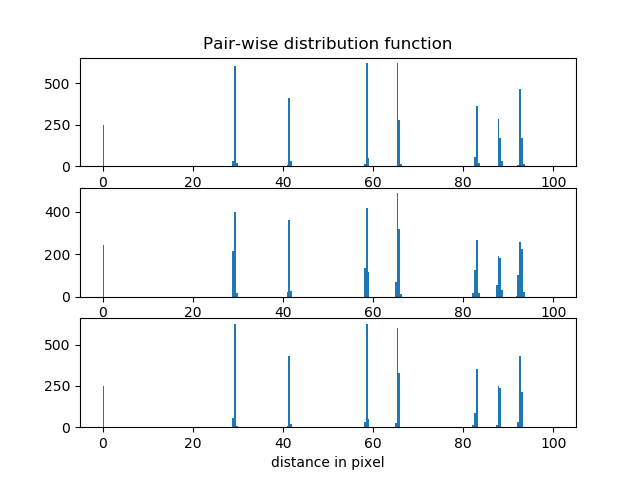

Text(0.5, 0, 'distance in pixel')

In [27]:
# pairwise distance calculation using scipy.spatial.distance_matrix

dist = [distance_matrix(i, i) for i in peaks_ref]

fig, ax = subplots(3)
for i in range(3):
    ax[i].hist(dist[i].ravel(), 250, range=(0,100))
ax[0].set_title("Pair-wise distribution function")
ax[2].set_xlabel("distance in pixel")

The histogram of the pair-distribution function has a first peak at 0 and the second peak between 29 and 30. Let’s start the fit with this value

Two other parameters correspond to the offset, in pixel for the grid index (X,Y) = (0,0). The easiest is to measure the smallest x and y for the first module.

In [28]:
#from pair-wise distribution histogram
step = 29.3

def index_module(module, position, step):
    "Return the peak position for the given module at the grid position. The guess parameter is also provided"
    indexed_module = yxi[position][yxi[position][:]["i"] == module]
    y_min = indexed_module["y"].min()
    x_min = indexed_module["x"].min()
    print("offset for the first peak: ", x_min, y_min)
    
    indexed = numpy.zeros(indexed_module.size, dtype=dl)
    delta_max = 0
    
    for i,v in enumerate(indexed_module):
        Y = int(round((v["y"] - y_min)/step))
        X = int(round((v["x"] - x_min)/step))
        indexed[i]["y"] = v["y"]
        indexed[i]["x"] = v["x"]
        indexed[i]["i"] = v["i"]
        indexed[i]["Y"] = Y
        indexed[i]["X"] = X
        #print(delta_max)
        delta_max = max(delta_max, sqrt((v["y"]-Y*step-y_min)**2 + (v["x"]-X*step-x_min)**2)/step)
        print("peak id: %2s %35s Y:%d (Δ=%.3f) X:%s (Δ=%.3f)"%
              (i,v, Y, (v["y"]-Y*step-y_min)/step, X, (v["x"]-X*step-x_min)/step))
    if delta_max>0.1: 
        print("Assignment is error prone with delta_max (in steps) =", delta_max)
    guess = [step, y_min, x_min, 0]
    return indexed, guess

#work with the first module and fit the peak positions
indexed1, guess1 = index_module(1, 0, step)
guess1

offset for the first peak:  2.052476167678833 6.0
peak id:  0     (123.48410541, 207.45542562, 1) Y:4 (Δ=0.010) X:7 (Δ=0.010)
peak id:  1      (123.59747732, 236.6557506, 1) Y:4 (Δ=0.014) X:8 (Δ=0.007)
peak id:  2       (123.17985493, 2.57148761, 1) Y:4 (Δ=-0.001) X:0 (Δ=0.018)
peak id:  3      (123.25800872, 31.71460831, 1) Y:4 (Δ=0.002) X:1 (Δ=0.012)
peak id:  4      (123.35842642, 90.25260955, 1) Y:4 (Δ=0.005) X:3 (Δ=0.010)
peak id:  5     (123.43735978, 148.85604818, 1) Y:4 (Δ=0.008) X:5 (Δ=0.010)
peak id:  6       (152.97377014, 2.05581188, 1) Y:5 (Δ=0.016) X:0 (Δ=0.000)
peak id:  7      (152.51041356, 31.59106046, 1) Y:5 (Δ=0.000) X:1 (Δ=0.008)
peak id:  8      (152.63233629, 90.28906977, 1) Y:5 (Δ=0.005) X:3 (Δ=0.011)
peak id:  9     (152.80133259, 148.82351807, 1) Y:5 (Δ=0.010) X:5 (Δ=0.009)
peak id: 10     (152.91486572, 236.64688599, 1) Y:5 (Δ=0.014) X:8 (Δ=0.007)
peak id: 11       (181.66608471, 2.49644381, 1) Y:6 (Δ=-0.005) X:0 (Δ=0.015)
peak id: 12      (181.81992741, 31.6

[29.3, 6.0, 2.052476167678833, 0]

The grid looks very well aligned with the axes which makes this step easier but nothing garanties it is perfect, so the rotation of the grid has to be measured as well.

The default rotation will be zero and will be fitted later on.

Once the indexes X,Y determined for eack peak, one can fit the parameter to properly align the grid with the first module. Those 4 parameters are step-size, x_min, y_min and angle

In [29]:
# Align center grid on module #9
indexed9, guess9 = index_module(9, 1, step)
guess9

offset for the first peak:  1983.78669282794 10.031553290784359
peak id:  0      (68.53318956, 1983.9473334, 9) Y:2 (Δ=-0.003) X:0 (Δ=0.005)
peak id:  1     (68.52492085, 2013.39607638, 9) Y:2 (Δ=-0.004) X:1 (Δ=0.011)
peak id:  2     (68.56618777, 2042.62876877, 9) Y:2 (Δ=-0.002) X:2 (Δ=0.008)
peak id:  3      (68.6289348, 2072.04879676, 9) Y:2 (Δ=-0.000) X:3 (Δ=0.012)
peak id:  4      (68.67246765, 2130.7804866, 9) Y:2 (Δ=0.001) X:5 (Δ=0.017)
peak id:  5     (68.60224375, 2189.44976753, 9) Y:2 (Δ=-0.001) X:7 (Δ=0.019)
peak id:  6    (126.94783784, 1984.12777565, 9) Y:4 (Δ=-0.010) X:0 (Δ=0.012)
peak id:  7     (126.8751576, 2013.45500252, 9) Y:4 (Δ=-0.012) X:1 (Δ=0.013)
peak id:  8    (126.95567599, 2042.78409229, 9) Y:4 (Δ=-0.009) X:2 (Δ=0.014)
peak id:  9    (127.07517209, 2072.16480435, 9) Y:4 (Δ=-0.005) X:3 (Δ=0.016)
peak id: 10    (127.15928899, 2130.88592764, 9) Y:4 (Δ=-0.002) X:5 (Δ=0.020)
peak id: 11    (127.15745774, 2189.65744391, 9) Y:4 (Δ=-0.003) X:7 (Δ=0.026)
peak id: 12  

[29.3, 10.031553290784359, 1983.78669282794, 0]

The error in positionning each of the pixel is less than 0.1 pixel which is already excellent and will allow a straight forward fit.

Let's do th same for the left and right grid positions:

In [30]:
# Align left grid on module #6
indexed6, guess6 = index_module(6, 0, step)
guess6

offset for the first peak:  1262.76739102602 6.5021456480026245
peak id:  0    (123.86860578, 1262.77460632, 6) Y:4 (Δ=0.006) X:0 (Δ=0.000)
peak id:  1    (123.73915467, 1321.47262728, 6) Y:4 (Δ=0.001) X:2 (Δ=0.004)
peak id:  2    (123.74013492, 1380.08734463, 6) Y:4 (Δ=0.001) X:4 (Δ=0.004)
peak id:  3    (123.61760235, 1409.49391153, 6) Y:4 (Δ=-0.003) X:5 (Δ=0.008)
peak id:  4    (123.64603654, 1438.67660466, 6) Y:4 (Δ=-0.002) X:6 (Δ=0.004)
peak id:  5    (123.68760154, 1468.00486562, 6) Y:4 (Δ=-0.000) X:7 (Δ=0.005)
peak id:  6    (153.12439226, 1262.79544121, 6) Y:5 (Δ=0.004) X:0 (Δ=0.001)
peak id:  7    (153.01401874, 1321.43544179, 6) Y:5 (Δ=0.000) X:2 (Δ=0.002)
peak id:  8    (153.00659179, 1380.08258364, 6) Y:5 (Δ=0.000) X:4 (Δ=0.004)
peak id:  9    (152.92952084, 1409.37969038, 6) Y:5 (Δ=-0.002) X:5 (Δ=0.004)
peak id: 10    (152.92040372, 1438.72945455, 6) Y:5 (Δ=-0.003) X:6 (Δ=0.006)
peak id: 11    (152.92236792, 1468.03059884, 6) Y:5 (Δ=-0.003) X:7 (Δ=0.006)
peak id: 12    (18

[29.3, 6.5021456480026245, 1262.76739102602, 0]

In [31]:
# Align right grid on module #12
indexed12, guess12 = index_module(12, 2, step)
guess12

offset for the first peak:  2852.8019351810217 8.436505198478699
peak id:  0   (154.89283001, 2940.90798742, 12) Y:5 (Δ=-0.001) X:3 (Δ=0.007)
peak id:  1   (154.74125573, 2911.58230206, 12) Y:5 (Δ=-0.007) X:2 (Δ=0.006)
peak id:  2   (154.71002036, 2882.29963639, 12) Y:5 (Δ=-0.008) X:1 (Δ=0.007)
peak id:  3   (154.68613148, 2853.03283477, 12) Y:5 (Δ=-0.009) X:0 (Δ=0.008)
peak id:  4     (8.64040324, 2940.72405878, 12) Y:0 (Δ=0.007) X:3 (Δ=0.001)
peak id:  5     (8.53160283, 2911.47199836, 12) Y:0 (Δ=0.003) X:2 (Δ=0.002)
peak id:  6      (8.56915843, 2882.1179322, 12) Y:0 (Δ=0.005) X:1 (Δ=0.001)
peak id:  7      (8.4365052, 2852.80193518, 12) Y:0 (Δ=0.000) X:0 (Δ=0.000)
peak id:  8    (67.10628749, 2940.83689539, 12) Y:2 (Δ=0.002) X:3 (Δ=0.005)
peak id:  9    (66.97670252, 2911.47377473, 12) Y:2 (Δ=-0.002) X:2 (Δ=0.002)
peak id: 10    (66.97839728, 2882.18239576, 12) Y:2 (Δ=-0.002) X:1 (Δ=0.003)
peak id: 11    (66.94455156, 2852.87055804, 12) Y:2 (Δ=-0.003) X:0 (Δ=0.002)
peak id: 12   (1

[29.3, 8.436505198478699, 2852.8019351810217, 0]

The error in positionning each of the pixel is less than 0.1 pixel which is already excellent and will allow a straight forward fit.

All rotations will be performed around the center of each module:

In [32]:
#Calculate the center of every single module for rotation around this center.
centers = {i: numpy.array([[numpy.where(mid == i)[1].mean()], [numpy.where(mid == i)[0].mean()]]) for i in range(1, 19)}
for k,v in centers.items():
    print(k,v.ravel())

1 [121.  97.]
2 [364.5  97. ]
3 [615.  97.]
4 [858.5  97. ]
5 [1109.   97.]
6 [1352.5   97. ]
7 [1603.   97.]
8 [1846.5   97. ]
9 [2097.   97.]
10 [2340.5   97. ]
11 [2591.   97.]
12 [2834.5   97. ]
13 [3085.   97.]
14 [3328.5   97. ]
15 [3579.   97.]
16 [3822.5   97. ]
17 [4073.   97.]
18 [4316.5   97. ]


In [33]:
# Define a rotation of a module around the center of the module ...

def rotate(angle, xy, module):
    "Perform the rotation of the xy points around the center of the given module"
    rot = [[cos(angle),-sin(angle)],
           [sin(angle), cos(angle)]]
    center = centers[module]
    return numpy.dot(rot, xy - center) + center

## Fit the grid on a reference module for each position

The cost function for the reference module for each grid position is calculated as the sum of distances squared in pixel space. It uses 4 parameters which are step-size, y_min, x_min, and angle

In [34]:
def cost_grid(param, module, indexed):
    """Cost function for moving the grid on a reference module
    contains: step, y_min, x_min, angle 
    returns the sum of distance squared in pixel space
    """
    step = param[0]
    y_min = param[1]
    x_min = param[2]
    angle = param[3]
    XY = numpy.vstack((indexed["X"], indexed["Y"]))
    xy_min = [[x_min], [y_min]]
    xy_guess = rotate(angle, step * XY + xy_min, module)
    delta = xy_guess - numpy.vstack((indexed["x"], indexed["y"]))
    return (delta*delta).sum()

In [35]:
def fit_grid(module, position, guess, indexed):
    """
    :param module: 
    
    :return: fit result of the grid aligned on the module
    """
    where = "left center right".split()[position]
    print(f"Align {where} position on module #{module}")
    print(f"Before optimization {guess} cost=", cost_grid(guess, module, indexed))
    res = minimize(cost_grid, guess, (module, indexed), method = "slsqp")
    print(res)
    print("Average displacement (pixels): ",sqrt(res.fun/len(indexed)))
    return res

In [36]:
# Alignment on the left side
res6 = fit_grid(6, 0, guess6, indexed6)
print("#"*50)
# Alignment on the center 
res9 = fit_grid(9, 1, guess9, indexed9)
print("#"*50)
# Alignment on the right side
res12 = fit_grid(12, 2, guess12, indexed12)

Align left position on module #6
Before optimization [29.3, 6.5021456480026245, 1262.76739102602, 0] cost= 1.0084329241894014
     fun: 0.4005870754906606
     jac: array([-0.00140484, -0.00022521, -0.00010474, -0.0436048 ])
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 2.93026713e+01,  6.52410817e+00,  1.26288272e+03, -2.52541487e-04])
Average displacement (pixels):  0.10548658096473437
##################################################
Align center position on module #9
Before optimization [29.3, 10.031553290784359, 1983.78669282794, 0] cost= 9.755912514600535
     fun: 2.6138054097864436
     jac: array([-0.00210944, -0.00034407, -0.00011811, -0.00777379])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 2.92981303e+01,  9.88812083e+00,  1.98421340e+03, -4.07650996e-04])
Average displacement (pixels):  0.269454459653



At this step, the grid is perfectly aligned with the first module. This module is used as the reference one and all other are aligned along it, using this first fit:

In [37]:
def index_positon(ref_module, position, guess, thres=1):
    """Return the indexed peak position for all the module for the grid position
    
    """    
    where = "left center right".split()[position]
    print(f"Aligning all peak positions of {where} position on module #{ref_module}")
    step, y_min, x_min, angle = guess
    xy = numpy.vstack((yxi[position]["x"], yxi[position]["y"]))
    indexed = numpy.zeros(xy.shape[1], dtype=dl)
    indexed["y"] = yxi[position]["y"]
    indexed["x"] = yxi[position]["x"]
    indexed["i"] = yxi[position]["i"]
    xy_min = [[x_min], [y_min]]
    XY_app = (rotate(-angle, xy, module=ref_module) - xy_min) / step
    XY_int = numpy.round((XY_app)).astype("int")
    indexed["X"] = XY_int[0]
    indexed["Y"] = XY_int[1]
    xy_guess = rotate(angle, step * XY_int + xy_min, module=ref_module)  
    err = (XY_app - XY_int)*step
    delta = numpy.sqrt((err**2).sum(axis=0))
    print(f"suspicious: {(delta>thres).sum()} / {delta.size} with threshold {thres}:")
    suspicious = indexed[numpy.where(abs(delta>thres))]
    print(suspicious)
    return indexed
    
print(len(index_positon(9, 1, guess=res9.x, thres=3)))
print(len(index_positon(6, 0, guess=res6.x, thres=1)))
print(len(index_positon(12, 2, guess=res12.x, thres=6)))

Aligning all peak positions of center position on module #9
suspicious: 9 / 242 with threshold 3:
[(69.6720044 , 2983.31674147, 13, 2, 34)
 (69.36312002, 2865.95335668, 12, 2, 30)
 (69.39535499, 2924.79366741, 12, 2, 32)
 (11.02989381, 2866.03500895, 12, 0, 30)
 (11.06291354, 2924.90754639, 12, 0, 32)
 (11.30030179, 2983.61285341, 13, 0, 34)
 (40.42757976, 2983.54515862, 13, 1, 34)
 (40.2171582 , 2865.98276701, 12, 1, 30)
 (40.24599957, 2924.85079978, 12, 1, 32)]
242
Aligning all peak positions of left position on module #6
suspicious: 5 / 248 with threshold 1:
[(152.51041356,  31.59106046, 1, 5, -42)
 (181.66608471,   2.49644381, 1, 6, -43)
 (  7.        , 412.        , 2, 0, -29)
 (  6.        ,  90.        , 1, 0, -40)
 ( 35.02235405,   2.8385089 , 1, 1, -43)]
248
Aligning all peak positions of right position on module #12
suspicious: 7 / 252 with threshold 6:
[( 41.14180143, 4408.21720226, 18, 1, 53)
 ( 40.99528235, 4349.52190217, 18, 1, 51)
 ( 11.92475192, 4408.41050243, 18, 0, 53

Only 7 peaks have an initial displacement of more than 6 pixels, all located in module 18, which is the furthest away from module 12. All other assignment are in 3 pixel on the left side and 1 pixel in the central position. 
The visual inspection confirms all localizations are valid.

There are 18 (half-)modules which have each of them 2 translations and one rotation. 
Only 7 of the are fitted in the first step. 
In addition to the step size, this represents 22 degrees of freedom for the fit. 
The first module is used to align the grid, all other modules are then aligned along this grid.

In [38]:
#his contains all peaks with their index
indexed = Triplet(index_positon(6, 0, guess=res6.x, thres=7),
                  index_positon(9, 1, guess=res9.x, thres=7),
                  index_positon(12, 2, guess=res12.x, thres=7))

Aligning all peak positions of left position on module #6
suspicious: 0 / 248 with threshold 7:
[]
Aligning all peak positions of center position on module #9
suspicious: 0 / 242 with threshold 7:
[]
Aligning all peak positions of right position on module #12
suspicious: 0 / 252 with threshold 7:
[]


The submodule cost funtion is the sum of the squares of the difference in the pixel space:


In [39]:
#here are defined the piot point for switching reference:
pivots = [6, 9, 12]

def submodule_cost(param, module, position):
    """contains: step, 
                 y_min_6L, x_min_6L, angle_6L,
                 y_min_9C, x_min_9C, angle_9C,
                 y_min_12R, x_min_12R, angle_12R,
                 
                 y_min_1, x_min_1, angle_1, 
                 y_min_2, x_min_2, angle_2, 
                 y_min_3, x_min_3, angle_3, ...

    :param: array with 64 parameters
    :param module: module number from 1 to 18
    :param position: 0, 1 or 2
    :returns: the sum of distance squared in pixel space for the given module with the given grid.
    
    """

    step = param[0]
    mask = indexed[position]["i"] == module
    if mask.sum() == 0 : 
        return 0
    substack = indexed[position][mask]
    pivot = pivots[position]

    y_min_grid, x_min_grid, angle_grid = param[1+3*(position): 4+3*(position)]

    XY = numpy.vstack((substack["X"], substack["Y"]))

    xy_min_grid = numpy.array([[x_min_grid], [y_min_grid]])
    xy_guess1 = rotate(angle_grid, step * XY + xy_min_grid, pivot)
    
    #print(y_min_grid, x_min_grid, angle_grid)

    if module == pivot:
        #print("Not much to do for reference module as it is naturally alligned")
        delta = xy_guess1 - numpy.vstack((substack["x"], substack["y"]))
    else:
        "perform the correction for given module"
        y_min, x_min, angle = param[7+3*module: 10+3*module]
        xy_min = numpy.array([[x_min], [y_min]])
        xy_guess = rotate(angle, xy_guess1 + xy_min, module)
        delta = xy_guess - numpy.vstack((substack["x"], substack["y"]))
        #print(y_min, x_min, angle)
    return (delta*delta).sum()

def print_res64(param):
    res = ["step: %.3f"%param[0]]
    f=lambda p:"Δx: %8.3f, Δy: %6.3f rot: %6.3f°"%(p[1], p[0], numpy.rad2deg(p[2]))
    res.append(f" {pivots[0]}L: {f(param[1:4])}")
    res.append(f" {pivots[1]}C: {f(param[4:7])}")
    res.append(f"{pivots[2]}R: {f(param[7:10])}")
    for i in range(1,19):
        w = "L" if i<min(pivots) else "R" if i>max(pivots) else "C"
        res.append("%2s%s: "%(i,w)+f(param[7+3*i:10+3*i]))
    print("\n".join(res))

submodule_cost(numpy.zeros(64), 1, 0)

1155395.4186643849

In [40]:
# Evaluated the guess and print the cost:
guess64 = numpy.zeros(64)
guess64[:4] = res6.x
guess64[4:7] = res9.x[1:]
guess64[7:10] = res12.x[1:]
print_res64(guess64)

step: 29.303
 6L: Δx: 1262.883, Δy:  6.524 rot: -0.014°
 9C: Δx: 1984.213, Δy:  9.888 rot: -0.023°
12R: Δx: 2852.995, Δy:  8.526 rot: -0.031°
 1L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 2L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 3L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 4L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 5L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 6C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 7C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 8C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 9C: Δx:    0.000, Δy:  0.000 rot:  0.000°
10C: Δx:    0.000, Δy:  0.000 rot:  0.000°
11C: Δx:    0.000, Δy:  0.000 rot:  0.000°
12C: Δx:    0.000, Δy:  0.000 rot:  0.000°
13R: Δx:    0.000, Δy:  0.000 rot:  0.000°
14R: Δx:    0.000, Δy:  0.000 rot:  0.000°
15R: Δx:    0.000, Δy:  0.000 rot:  0.000°
16R: Δx:    0.000, Δy:  0.000 rot:  0.000°
17R: Δx:    0.000, Δy:  0.000 rot:  0.000°
18R: Δx:    0.000, Δy:  0.000 rot:  0.000°


In [41]:
print("\nContribution to the total cost of each module/position")
for m in range(1,19):
    print(m, "%10f\t %10f\t %10f"%tuple(submodule_cost(guess64, m, i) for i in range(3)))


Contribution to the total cost of each module/position
1  24.826157	   0.000000	   0.000000
2  30.830841	   0.000000	   0.000000
3   7.344038	   0.000000	   0.000000
4   7.663460	   0.000000	   0.000000
5   2.550971	   0.000000	   0.000000
6   0.400587	  46.645576	   0.000000
7   6.197928	  54.642867	   0.000000
8   0.000000	  26.282775	   0.000000
9   0.000000	   2.634829	   0.000000
10   0.000000	  23.952675	   0.000000
11   0.000000	 145.809063	   0.000000
12   0.000000	 172.923881	   1.338200
13   0.000000	  56.798249	  20.032290
14   0.000000	   0.000000	 138.498810
15   0.000000	   0.000000	 223.065342
16   0.000000	   0.000000	 274.254700
17   0.000000	   0.000000	 639.247775
18   0.000000	   0.000000	 527.538350


## Fit all modules of the central grid position:

In [42]:
# Fit the center position:

def cost_all_center(param):
    """contains: step, y_min_1, x_min_1, angle_1, ...
    returns the sum of distance squared in pixel space
    """
    return sum(submodule_cost(param, module=i, position=1) for i in range(6,13))

print_res64(guess64)
print(cost_all_center(guess64))
res_center = minimize(cost_all_center, guess64, method = "slsqp")
print_res64(res_center.x)
print(res_center)

step: 29.303
 6L: Δx: 1262.883, Δy:  6.524 rot: -0.014°
 9C: Δx: 1984.213, Δy:  9.888 rot: -0.023°
12R: Δx: 2852.995, Δy:  8.526 rot: -0.031°
 1L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 2L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 3L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 4L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 5L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 6C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 7C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 8C: Δx:    0.000, Δy:  0.000 rot:  0.000°
 9C: Δx:    0.000, Δy:  0.000 rot:  0.000°
10C: Δx:    0.000, Δy:  0.000 rot:  0.000°
11C: Δx:    0.000, Δy:  0.000 rot:  0.000°
12C: Δx:    0.000, Δy:  0.000 rot:  0.000°
13R: Δx:    0.000, Δy:  0.000 rot:  0.000°
14R: Δx:    0.000, Δy:  0.000 rot:  0.000°
15R: Δx:    0.000, Δy:  0.000 rot:  0.000°
16R: Δx:    0.000, Δy:  0.000 rot:  0.000°
17R: Δx:    0.000, Δy:  0.000 rot:  0.000°
18R: Δx:    0.000, Δy:  0.000 rot:  0.000°
472.89166632459916
step: 29.287
 6L: Δx: 1262.883, Δy:  6.524 rot: -0.014°
 9C: Δx: 

## Fit all modules of the left grid position:

In [43]:
def cost_all_left(param):
    """contains: step, y_min_1, x_min_1, angle_1, ...
    returns the sum of distance squared in pixel space
    """
    return sum(submodule_cost(param, module=i, position=0) for i in range(1,6))

print_res64(res_center.x)
print(cost_all_left(res_center.x))
res_left = minimize(cost_all_left, res_center.x, method = "slsqp")
print_res64(res_left.x)
print(res_left)

step: 29.287
 6L: Δx: 1262.883, Δy:  6.524 rot: -0.014°
 9C: Δx: 1984.248, Δy:  9.923 rot: -0.023°
12R: Δx: 2852.995, Δy:  8.526 rot: -0.031°
 1L: Δx:   -0.000, Δy:  0.000 rot: -0.000°
 2L: Δx:    0.000, Δy:  0.000 rot: -0.000°
 3L: Δx:    0.000, Δy:  0.000 rot: -0.000°
 4L: Δx:   -0.000, Δy:  0.000 rot: -0.000°
 5L: Δx:    0.000, Δy:  0.000 rot:  0.000°
 6C: Δx:   -1.038, Δy: -1.262 rot: -0.319°
 7C: Δx:   -0.455, Δy: -1.318 rot:  0.016°
 8C: Δx:   -0.136, Δy: -0.641 rot:  0.004°
 9C: Δx:    0.000, Δy:  0.000 rot:  0.000°
10C: Δx:    0.798, Δy:  0.357 rot:  0.010°
11C: Δx:    1.866, Δy:  0.705 rot:  0.062°
12C: Δx:    2.872, Δy:  1.060 rot:  0.095°
13R: Δx:    0.000, Δy:  0.000 rot:  0.000°
14R: Δx:    0.000, Δy:  0.000 rot:  0.000°
15R: Δx:    0.000, Δy:  0.000 rot:  0.000°
16R: Δx:    0.000, Δy:  0.000 rot:  0.000°
17R: Δx:    0.000, Δy:  0.000 rot:  0.000°
18R: Δx:    0.000, Δy:  0.000 rot:  0.000°
177.23098745415305
step: 29.318
 6L: Δx: 1262.815, Δy:  6.800 rot:  0.018°
 9C: Δx: 

## Fit all modules of the right grid position:

In [44]:
def cost_all_right(param):
    """contains: step, y_min_1, x_min_1, angle_1, ...
    returns the sum of distance squared in pixel space
    """
    return sum(submodule_cost(param, module=i, position=2) for i in range(13,19))

bounds = [(None, None) for i in range(64)]
bounds[0] = (29, 30)
for i in range(3, 64, 3):
    bounds[i] = (-.1, .1) #limit rotations


print_res64(res_left.x)
print(cost_all_right(res_left.x))
res_right = minimize(cost_all_right, res_left.x, method = "slsqp", bounds=bounds)
print_res64(res_right.x)
print(res_right)

step: 29.318
 6L: Δx: 1262.815, Δy:  6.800 rot:  0.018°
 9C: Δx: 1984.248, Δy:  9.923 rot: -0.023°
12R: Δx: 2852.995, Δy:  8.526 rot: -0.031°
 1L: Δx:    0.128, Δy: -0.273 rot:  0.035°
 2L: Δx:   -0.215, Δy: -0.023 rot:  0.005°
 3L: Δx:   -0.014, Δy:  0.313 rot:  0.048°
 4L: Δx:   -0.023, Δy:  0.242 rot: -0.044°
 5L: Δx:    0.057, Δy:  0.017 rot: -0.023°
 6C: Δx:   -1.038, Δy: -1.262 rot: -0.319°
 7C: Δx:   -0.455, Δy: -1.318 rot:  0.016°
 8C: Δx:   -0.136, Δy: -0.641 rot:  0.004°
 9C: Δx:    0.000, Δy:  0.000 rot:  0.000°
10C: Δx:    0.798, Δy:  0.357 rot:  0.010°
11C: Δx:    1.866, Δy:  0.705 rot:  0.062°
12C: Δx:    2.872, Δy:  1.060 rot:  0.095°
13R: Δx:    0.000, Δy:  0.000 rot:  0.000°
14R: Δx:    0.000, Δy:  0.000 rot:  0.000°
15R: Δx:    0.000, Δy:  0.000 rot:  0.000°
16R: Δx:    0.000, Δy:  0.000 rot:  0.000°
17R: Δx:    0.000, Δy:  0.000 rot:  0.000°
18R: Δx:    0.000, Δy:  0.000 rot:  0.000°
1624.498037717492
step: 29.317
 6L: Δx: 1262.815, Δy:  6.800 rot:  0.018°
 9C: Δx: 1

## Fit all modules togeather

In [45]:
def cost_all(param):
    """contains: step, y_min_1, x_min_1, angle_1, ...
    returns the sum of distance squared in pixel space
    """
    return (sum(submodule_cost(param, module=i, position=0) for i in range(1, 19))+
            sum(submodule_cost(param, module=i, position=1) for i in range(1, 19))+
            sum(submodule_cost(param, module=i, position=2) for i in range(1, 19)))

print_res64(res_right.x)
print(cost_all(res_right.x))
res_all = minimize(cost_all, res_right.x, method = "slsqp")
print_res64(res_all.x)
print(res_all)

step: 29.317
 6L: Δx: 1262.815, Δy:  6.800 rot:  0.018°
 9C: Δx: 1984.248, Δy:  9.923 rot: -0.023°
12R: Δx: 2853.223, Δy:  9.943 rot:  0.019°
 1L: Δx:    0.128, Δy: -0.273 rot:  0.035°
 2L: Δx:   -0.215, Δy: -0.023 rot:  0.005°
 3L: Δx:   -0.014, Δy:  0.313 rot:  0.048°
 4L: Δx:   -0.023, Δy:  0.242 rot: -0.044°
 5L: Δx:    0.057, Δy:  0.017 rot: -0.023°
 6C: Δx:   -1.038, Δy: -1.262 rot: -0.319°
 7C: Δx:   -0.455, Δy: -1.318 rot:  0.016°
 8C: Δx:   -0.136, Δy: -0.641 rot:  0.004°
 9C: Δx:    0.000, Δy:  0.000 rot:  0.000°
10C: Δx:    0.798, Δy:  0.357 rot:  0.010°
11C: Δx:    1.866, Δy:  0.705 rot:  0.062°
12C: Δx:    2.872, Δy:  1.060 rot:  0.095°
13R: Δx:   -0.678, Δy: -0.961 rot:  0.118°
14R: Δx:   -0.546, Δy: -0.232 rot:  0.073°
15R: Δx:   -0.064, Δy:  0.161 rot:  0.077°
16R: Δx:    0.314, Δy:  0.474 rot:  0.041°
17R: Δx:    0.489, Δy:  0.853 rot:  0.104°
18R: Δx:    0.785, Δy:  1.104 rot:  0.107°
286.9253604833995
step: 29.337
 6L: Δx: 1262.787, Δy:  6.450 rot:  0.065°
 9C: Δx: 1

In [46]:
print("\nContribution to the total cost of each module/position")
for m in range(1,19):
    print(m, "%10f\t %10f\t %10f"%tuple(submodule_cost(res_all.x, m, i) for i in range(3)))


Contribution to the total cost of each module/position
1   2.039613	   0.000000	   0.000000
2   1.210256	   0.000000	   0.000000
3   0.190349	   0.000000	   0.000000
4   0.183149	   0.000000	   0.000000
5   0.275586	   0.000000	   0.000000
6   1.697139	   2.102508	   0.000000
7   1.282125	   7.021708	   0.000000
8   0.000000	   7.179923	   0.000000
9   0.000000	   5.218332	   0.000000
10   0.000000	   3.490934	   0.000000
11   0.000000	   4.629880	   0.000000
12   0.000000	   3.613336	   4.132159
13   0.000000	  11.716391	   3.812574
14   0.000000	   0.000000	   1.124010
15   0.000000	   0.000000	   0.521406
16   0.000000	   0.000000	   0.611842
17   0.000000	   0.000000	   2.221702
18   0.000000	   0.000000	   2.184698


# Reconstruction of the pixel position

The pixel position can be obtained from the standard Pilatus detector. Each module is then displaced according to the fitted values, except the first one which is left where it is.

In [47]:
pixel_coord = pyFAI.detector_factory("Pilatus900kwCdTe").get_pixel_corners()
pixel_coord_raw = pixel_coord.copy()

def correct(x, y, dx, dy, angle, module):
    "apply the correction dx, dy and angle to those pixels ..."
    trans = numpy.array([[dx],
                         [dy]])
    xy_guess = numpy.vstack((x.ravel(), 
                             y.ravel()))
    xy_cor = rotate(-angle, xy_guess, module) - trans
    xy_cor.shape = ((2,)+x.shape)
    return xy_cor[0], xy_cor[1]


for module in range(1, 19):
    # Extract the pixel corners for one module
    module_idx = numpy.where(mid == module)
    one_module = pixel_coord_raw[module_idx]


    #retrieve the fitted values
    dy, dx, angle = res_all.x[7+3*module: 10+3*module]

    #z = one_module[...,0]
    y = one_module[...,1]/pilatus.pixel1
    x = one_module[...,2]/pilatus.pixel2
    
    x_cor, y_cor = correct(x, y, dx, dy, angle, module)
    if i>12:
        dy, dx, angle = res_all.x[7+3*12: 10+3*12]
        x_cor, y_cor = correct(x_cor, y_cor, dx, dy, angle, 12)
    if i<6:
        dy, dx, angle = res_all.x[7+3*6: 10+3*6]
        x_cor, y_cor = correct(x_cor, y_cor, dx, dy, angle, 6)
    
    one_module[...,1] = y_cor * pilatus.pixel1
    one_module[...,2] = x_cor * pilatus.pixel2
    #Update the array
    pixel_coord_raw[module_idx] = one_module


In [48]:
pilatus.set_pixel_corners(pixel_coord_raw)
pilatus.mask = mask0 | mask1 | mask2
pilatus.save("Pilatus_ID09_v0.h5")

<IPython.core.display.Javascript object>


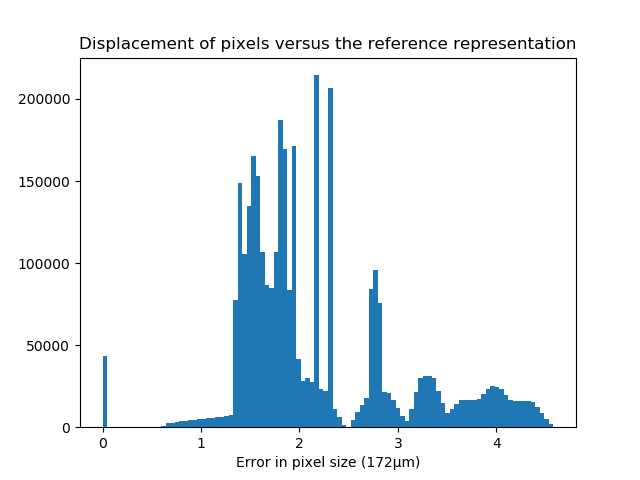

Text(0.5, 0, 'Error in pixel size (172µm)')

In [49]:
displ = numpy.sqrt(((pixel_coord - pixel_coord_raw)**2).sum(axis=-1))
displ /= pilatus.pixel1 #convert in pixel units
fig, ax = subplots()
ax.hist(displ.ravel(), 100)
ax.set_title("Displacement of pixels versus the reference representation")
ax.set_xlabel("Error in pixel size (172µm)")

In [50]:
#Kabsch alignment of the whole detector ... 

unmasked = numpy.logical_not(all_masks)
misaligned = numpy.vstack((pixel_coord_raw[..., 2].ravel(), #x
                           pixel_coord_raw[..., 1].ravel())) #y

reference = numpy.vstack((pixel_coord[..., 2].ravel(), #x
                          pixel_coord[..., 1].ravel())) #y

def kabsch(P, R):
    "Align P on R"
    centroid_P = P.mean(axis=0)
    centroid_R = R.mean(axis=0)
    centered_P = P - centroid_P
    centered_R = R - centroid_R
    C = numpy.dot(centered_P.T, centered_R)
    V, S, W = numpy.linalg.svd(C)
    d = (numpy.linalg.det(V) * numpy.linalg.det(W)) < 0.0
    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]
    # Create Rotation matrix U
    U = numpy.dot(V, W)
    P = numpy.dot(centered_P, U)
    return P + centroid_R
    
%time aligned = kabsch(misaligned.T, reference.T).T

CPU times: user 352 ms, sys: 291 ms, total: 643 ms
Wall time: 88.1 ms


<IPython.core.display.Javascript object>


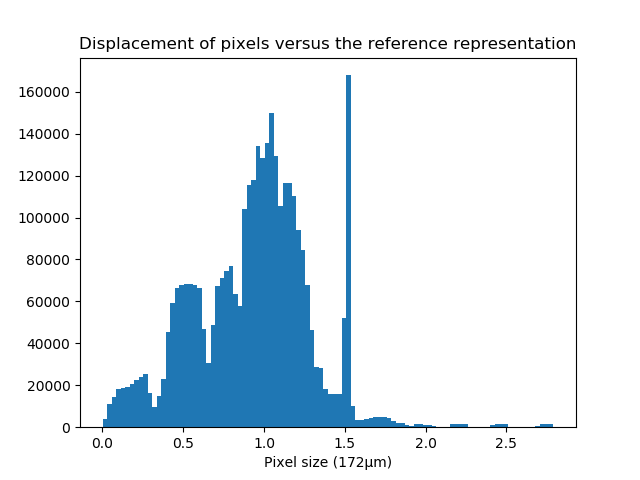

Text(0.5, 0, 'Pixel size (172µm)')

In [51]:
displ = numpy.sqrt(((aligned-reference)**2).sum(axis=0))
displ /= pilatus.pixel1 #convert in pixel units
fig, ax = subplots()
ax.hist(displ.ravel(), 100)
ax.set_title("Displacement of pixels versus the reference representation")
ax.set_xlabel("Pixel size (172µm)")

In [52]:
pixel_coord_aligned = pixel_coord.copy()
pixel_coord_aligned[...,1] = aligned[1,:].reshape(pixel_coord.shape[:-1])
pixel_coord_aligned[...,2] = aligned[0,:].reshape(pixel_coord.shape[:-1])

pilatus.set_pixel_corners(pixel_coord_aligned)
pilatus.mask = all_masks
pilatus.save("Pilatus_ID09_final.h5")

<IPython.core.display.Javascript object>


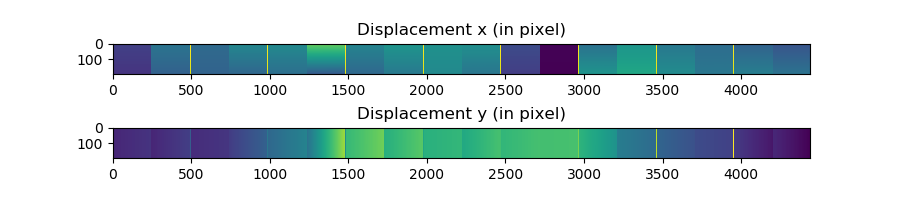

Text(0.5, 1.0, 'Displacement y (in pixel)')

In [53]:
fig, ax = subplots(2, figsize=(9, 2))
ax[0].imshow((pixel_coord_aligned[...,2].mean(axis=-1) - pixel_coord[...,2].mean(axis=-1))/pilatus.pixel2)
ax[0].set_title("Displacement x (in pixel)")
ax[1].imshow((pixel_coord_aligned[...,1].mean(axis=-1) - pixel_coord[...,1].mean(axis=-1))/pilatus.pixel1)
ax[1].set_title("Displacement y (in pixel)")

## Conclusion

This tutorial presents the way to calibrate a large module based detector using a small grid.
The HDF5 file generated is directly useable by any parts of pyFAI, the reader is invited in calibrating the rings images with the default definition and with this optimized definition and check the residual error is almost divided by a factor two.

To come back on the precision of the localization of the pixel: not all the pixel are within the specifications provided by Dectris which claims the misaliment of the modules is within one pixel.

**Nota:** There is not validation yet of this modelization of the detector. There has been no parallax effect corrections so far.

In [54]:
print("total time: ", time.time() - start_time, "s")

total time:  33.878681898117065 s
